## FDP inference within selected clusters

Import the necessary packages

In [1]:
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt 
import sys
#sys.path.insert(0, 'C:\\Users\\12SDa\\davenpor\\davenpor\\Toolboxes\\pyrft' )
import pyrft as pr
import sanssouci as sa

/home/thirion/mygit/nilearn/nilearn/datasets/__init__.py:92: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


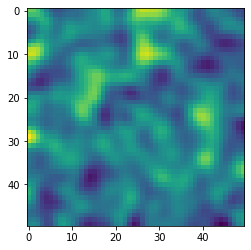

In [2]:
# Set the dimension of the example and the number of subjects
Dim = (50,50)
N = 30
m = np.prod(Dim)

# Generate the category vector and obtain the corresponding design matrix
from sklearn.utils import check_random_state
rng = check_random_state(101)
categ = rng.choice(3, N, replace = True)
X = pr.group_design(categ); 

# Specify the contrast matrix (here 2 contrasts are chosen)
C = np.array([[1, -1, 0], [0, 1, -1]])

# Calulate the number contrasts
L = C.shape[0]

# Calculate the number of p-values generated (L for each voxels)
npvals = m * L

# Generate a stationary random field with given FWHM
FWHM = 4
lat_data = pr.statnoise(Dim, N, FWHM)

# Plot a sample realization of the noise
plt.imshow(lat_data.field[:, :, 1])  

Calculate the t-statistics

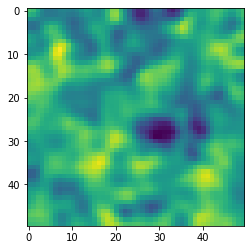

In [3]:
tstat_image, residuals = pr.contrast_tstats(lat_data, X, C)
plt.imshow(tstat_image.field[:, :, 1])

In [4]:
# Specify the number of bootstraps to use
B = 100
alpha = 0.1

# Run the bootstrapped algorithm
minPperm, orig_pvalues, pivotal_stats, bs = pr.boot_contrasts(lat_data, X, C, B, 'linear', True, 1)

# Calculate the post-hoc bound
lambda_quant = np.quantile(pivotal_stats, alpha)
print('Lambda Quantile:', lambda_quant)

# Calculate the number of voxels in the mask
m = np.sum(lat_data.mask)

# Gives t_k^L(lambda) = lambda*k/m for k = 1, ..., m
thr = sa.t_linear(lambda_quant, np.arange(1, m + 1), m)

(5000, 100)
(1, 5000)
Lambda Quantile: 0.2393270456147734


In [6]:
clusters = pr.find_clusters(orig_pvalues.field[:, :, 1], cdt=0.01, below=1)
# plt.imshow(clusters)
print(clusters)

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), array([ 9.,  5.,  1.,  9., 29.]))


In [7]:
n_clusters = len(clusters[1])
for I in np.arange(n_clusters):
    voxelsincluster = np.array(clusters[0] == (I + 1), dtype = bool)
    cluster_pvalues = orig_pvalues.field[:, :, 1][voxelsincluster]
    bound = sa.max_fp(cluster_pvalues, thr)
    print(bound)
    print(np.sum(voxelsincluster == 1))

9.0
9
5.0
5
1.0
1
9.0
9
26.0
29


## Add some spatial signal

In [8]:
signal = np.zeros(Dim)
signal[10:20,10:20] = 0.4
signal[30:35,30:35] = 0.4
w2 = np.where(categ == 2)[0]

# Add the signal to the field
for I in np.arange(len(w2)):
    lat_data.field[:, :, w2[I]] = lat_data.field[:, :, w2[I]] + signal


In [9]:
# Specify the number of bootstraps to use
B = 100
alpha = 0.1

# Run the bootstrapped algorithm
minPperm, orig_pvalues, pivotal_stats, bs = pr.boot_contrasts(lat_data, X, C, B, 'linear', True, 1)

# Calculate the post-hoc bound
lambda_quant = np.quantile(pivotal_stats, alpha)
print('Lambda Quantile:', lambda_quant)

# Calculate the number of voxels in the mask
m = np.sum(lat_data.mask)

# Gives t_k^L(lambda) = lambda*k/m for k = 1, ..., m
thr = sa.t_linear(lambda_quant, np.arange(1, m + 1), m)

(5000, 100)
(1, 5000)
Lambda Quantile: 0.275275149472422


In [10]:
clusters = pr.find_clusters(orig_pvalues.field[:, :, 1], cdt=0.01, below=1)
#plt.imshow(clusters)

In [11]:
n_clusters = len(clusters[1])
for I in np.arange(n_clusters):
    voxelsincluster = np.array(clusters[0] == (I + 1), dtype = bool)
    cluster_pvalues = orig_pvalues.field[:, :, 1][voxelsincluster]
    bound = len(cluster_pvalues) - sa.max_fp(cluster_pvalues, thr)
    print(bound)
    print(np.sum(voxelsincluster == 1))

71.0
93
0.0
1
25.0
25
0.0
1
